# Predicting Plus/Minus in the NBA

A peculiar and often misunderstood player statistic in the NBA is the "plus/minus" category. A quick Google search results in the following definition for plus/minus:

"The plus/minus statistic is a measure of the point differential when players are in and out of a game. It is calculated by taking the difference in the score when the player enters the game and subtracting it from the score when the player exits the game. These differences are added up over the entire game to give the score. Thus, it is a measure of the impact a player has on the score of the game when he is in the game without measuring any specific statistic."

Notice the sentence at the end of the definition: "...it is a measure of the impact a player has on the score of the game when he is in the game *without* measuring any specfic statistic."

One way to interpret this is to say that, the plus/minus category for a player's statistics should, *a priori*, have *no* dependency on any other statistic. 

Of course, *this can't possibly be true!* From a holistic point of view, plus/minus is a clear indicator of the *effectiveness* of a player. In fact, one could argue that being positive in the plus/minus category throughout your career means you had, at the very least, a productive NBA career. To say that the plus/minus category has no dependency on other statistics can't be a fact, but instead, must be a consequence of *ignorance*.

In this Jupyter Notebook, we will reconcile this ignorance by analyzing data from the 2015-2016 NBA Regular Season. We will use two basic machine learning models to aid in our analysis: k-nearest neighbors and linear regression. The kinds of questions we'd like to answer are the following:

1. Can we train a model to predict plus/minus from players' statistics? How well will this model perform?
2. How can we determine good training data in order to build our model?
3. Is there a factor/group of factors that has a high correlation with plus/minus? If so, which one(s)?

On that note, let's get started!

By the way, you might ask, "Why use data from the 2015-2016 Regular Season?" For basketball fans, you may remember that this is the season in which the *greatest NBA team to have every played the game of basketball* achieved a remarkable, almost anomalous, feat: a regular season record of 73 - 9. This Jupyter Notebook is an homage to their greatness. #dubnation

First, we'll import all the libraries we'll need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

Now let's load the data we'll be working with:

In [2]:
NBA_data = pd.read_csv("NBA_Regular_Season.csv")

Let's take a look at the first few rows of this data set.

In [3]:
NBA_data.head(20)

,PLAYER,TEAM,AGE,GP,W,MIN,PTS,FGM,FGA,3PM,...,DREB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,plus/minus
0,Alan Anderson,WAS,33,13,8,14.8,5.0,1.6,4.5,0.9,...,2.0,1.1,0.2,0.3,0.1,1.9,10.1,0,0,2.3
1,Bradley Beal,WAS,23,55,28,31.1,17.4,6.5,14.5,1.9,...,2.7,2.9,2.0,1.0,0.2,2.1,27.4,0,0,-0.4
2,DeJuan Blair,WAS,27,29,12,7.5,2.1,1.0,2.3,0.0,...,1.3,0.4,0.5,0.3,0.1,1.8,5.5,0,0,-1.3
3,Drew Gooden,WAS,34,30,18,10.2,2.7,1.1,3.4,0.2,...,1.9,0.4,0.4,0.3,0.4,1.3,8.3,2,0,-2.8
4,Garrett Temple,WAS,30,80,40,24.4,7.3,2.5,6.3,1.1,...,2.2,1.8,0.8,0.9,0.2,2.4,15.5,0,0,-0.5
5,Gary Neal,WAS,31,40,18,20.2,9.8,3.8,8.1,1.0,...,1.8,1.2,0.7,0.5,0.0,1.4,14.9,0,0,-4.1
6,JJ Hickson,WAS,27,35,17,12.5,5.9,2.3,4.4,0.0,...,2.7,0.7,0.7,0.4,0.4,1.3,13.2,2,0,-1.7
7,Jared Dudley,WAS,30,81,40,25.9,7.9,2.9,6.0,1.2,...,2.9,2.1,1.0,0.9,0.2,2.3,17.7,0,0,0.7
8,Jarell Eddie,WAS,24,26,13,5.6,2.4,0.8,2.5,0.6,...,0.8,0.2,0.0,0.2,0.0,0.2,4.4,0,0,-1.3
9,John Wall,WAS,25,77,37,36.2,19.9,7.4,17.5,1.5,...,4.4,10.2,4.1,1.9,0.8,2.1,45.0,49,4,1.3


This data set keeps track of the *per-game* statistics of every player in the NBA during the 2015-2016 Regular Season. It is, currently, sorted by Teams, in reverse alphabetical order (within each team, it is sorted in alphabetical order by the last name of the player).

Now, recall that the stat line we are interested in is the 'plus/minus' category. If you've forgotten, you can refer to the definition of 'plus/minus' laid out at the beginning of the notebook, but here is a terse defintion: 'plus/minus' is an indication of whether a player generally closes the gap between the score if their team is behind, and retains the lead if their team is ahead. As such, you can imagine that the 'plus/minus' stat is one in which coaches/team managers care about a lot. It's a very good metric of player effectiveness. 

What makes the 'plus/minus' category such an interesting statistic is that, it's not immediately clear how 'plus/minus' relates to all of the other features on a stat sheet. To get a feel for why this is true, lets go ahead and inspect the 'plus/minus' column. 

In [4]:
NBA_data["plus/minus"].describe()

count    476.000000
mean      -0.394958
std        3.076412
min      -10.000000
25%       -2.000000
50%       -0.500000
75%        1.100000
max       13.200000
Name: plus/minus, dtype: float64

Notice that the average 'plus/minus' hovers right around zero: the typical NBA player doesn't drag their team down, nor do they elevate their them to massive successes. But we also see that there was a player who had a 'plus/minus' of +13.2! Which is absolutely insane! Who was that player?

In [5]:
print(NBA_data[NBA_data['plus/minus'] == 13.2])

             PLAYER TEAM  AGE  GP  W    MIN   PTS  FGM   FGA  3PM     ...      \
324  Draymond Green  GSW   26  81  73  34.7  14.0  5.0  10.1  1.2     ...       

     DREB  AST  TOV  STL  BLK   PF    FP  DD2  TD3  plus/minus  
324   7.8  7.4  3.2  1.5  1.4  3.0  41.8   33   13        13.2  

[1 rows x 24 columns]


Ahh, of course, the ineffable Draymond Green. 

Now, notice that, despite Draymond's rediculous high 'plus/minus' stat, *Draymond would not be classified as a high volume scorer*. I mean, the guy only averaged 14 points a game! So, we already have our first simple insight:

### Insight 1: High volume scoring is not the sole indicator of a high plus/minus

In fact, let's look at the top five scorers, and let's check our their plus/minuses:

In [6]:
print(NBA_data['PTS'].sort_values(ascending=False).head(5))

334    30.1
310    29.0
149    28.2
70     26.9
391    25.3
Name: PTS, dtype: float64


In [7]:
for i in [334, 310, 149, 70, 391]:
    print(NBA_data.loc[i,'plus/minus'])

12.9
1.5
9.0
0.6
8.1


This is peculiar, right?! I mean, one would think that being a top five scorer in the NBA should label you as an 'effective player', and yet, we see that the second and fourth highest scorers are within a standard deviation of the average plus/minus! What gives?!

By now, you should be convinced that the 'plus/minus' category, despite its utility for analytics, is quite subtle. Therefore, we're going to see if we can gain insight into the plus/minus category by training regression models on our data.

First thing's first, we need to clean up our data a bit. Let's first check out exactly what stats this data set is keeping track of:

In [8]:
print(NBA_data.columns)

Index(['PLAYER', 'TEAM', 'AGE', 'GP', 'W ', 'MIN', 'PTS', 'FGM', 'FGA', '3PM',
       '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'PF',
       'FP', 'DD2', 'TD3', 'plus/minus'],
      dtype='object')


Now let's clean the dataset and prepare it for model training.

We'll proceed to either get rid of columns that are clearly not relevant in our analysis, and also combine certain columns that are redundant.

The categories that will not go into our analysis are: age, games played, games won, fantasy points, total number of double-doubles, and total number of triple-doubles. Let's go ahead and get rid of those:

In [9]:
NBA_data_cleaned = NBA_data.copy()

for i in ['AGE', 'GP', 'W ', 'FP', 'DD2', 'TD3']:
    NBA_data_cleaned = NBA_data_cleaned.drop(i, axis=1)

Now we can turn certain pairs of columns into a single column. For example, instead of having one column for three pointers made and one columns for three pointers attempted, we can just have one column for three-point percentage. Similarly, instead of two columns for offensive and defensive rebounds, let's simplify to one column for total rebounds.

In [10]:
NBA_data_cleaned['3P%'] = NBA_data_cleaned['3PM']/NBA_data_cleaned['3PA']
NBA_data_cleaned['FG%'] = NBA_data_cleaned['FGM']/NBA_data_cleaned['FGA']
NBA_data_cleaned['FT%'] = NBA_data_cleaned['FTM']/NBA_data_cleaned['FTA']
NBA_data_cleaned['REB'] = NBA_data_cleaned['OREB'] + NBA_data_cleaned['DREB']

for i in ['3PM', '3PA', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB']:
    NBA_data_cleaned = NBA_data_cleaned.drop(i, axis=1)

Let's check for null values to make sure our data is fully cleaned

In [11]:
print(NBA_data_cleaned.isnull().sum())

PLAYER         0
TEAM           0
MIN            0
PTS            0
AST            0
TOV            0
STL            0
BLK            0
PF             0
plus/minus     0
3P%           79
FG%            1
FT%           14
REB            0
dtype: int64


Everything looks fine, except that we have to take into account all the scrubs in the league who didn't attempt any three pointers/field goals/free throws. Clearly, if those players didn't have any attempts in these categories, it means they didn't make any either, so although Python says these are null values due to division by zero, these should clearly be set to zero.

In [12]:
for i in ['3P%', 'FG%', 'FT%']:
    NBA_data_cleaned[i][NBA_data_cleaned[i].isnull()] = 0

/Users/aafandi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
print(NBA_data_cleaned.isnull().sum())

PLAYER        0
TEAM          0
MIN           0
PTS           0
AST           0
TOV           0
STL           0
BLK           0
PF            0
plus/minus    0
3P%           0
FG%           0
FT%           0
REB           0
dtype: int64


Much better.

Now that the data is prepared, let's run some machine learning models. We'll start with k-nearest neighbors. To begin, let's train the model on one feature at a time. To keep things simple, let's use 2-fold cross validation.  

In [14]:
# Define a function that runs 2-fold cross validation on a k-nearest neighbors model. Returns root mean squared error

relevant_features = ['MIN', 'PTS', 'AST', 'TOV', 'STL', 'BLK', 'PF', '3P%', 'FG%', 'FT%', 'REB']

def KNN(feature, k):
    knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
    kf = KFold(n_splits = 2, shuffle = True, random_state = 1)
    neg_mse = cross_val_score(estimator = knn, X = NBA_data_cleaned[[feature]], y = NBA_data_cleaned[['plus/minus']],
                             cv = kf, scoring = 'neg_mean_squared_error')
    return (np.absolute(neg_mse)**(1/2)).mean()

# As k ranges from 1 to 10, keep track of the smallest rmse for each feature

def Min_RMSE_KNN(feature):
    l = []
    for k in [i for i in range(1, 11)]:
        l.append(KNN(feature, k))
    return min(l), feature

# Return a sorted (ascending) list of the smallest rmses
smallest_rmse_knn = [Min_RMSE_KNN(feature) for feature in relevant_features]

smallest_rmse_knn.sort()

print(smallest_rmse_knn)

[(3.0191100536577844, 'PTS'), (3.0520003803445572, 'MIN'), (3.055090656048093, 'BLK'), (3.097412388046357, 'FT%'), (3.118165902166925, 'STL'), (3.128018490994335, 'FG%'), (3.144615764512799, '3P%'), (3.1475164118142462, 'AST'), (3.1629483161390253, 'TOV'), (3.2177610626161193, 'REB'), (3.2886800850085995, 'PF')]


With these calculations, we now have our next insight:

### Insight 2: When using a single feature to train a k-nearest neighbors model to predict plus/minus, the top six features which result in the least error in the model are points, minutes, blocks, free-throw percentage, steals, and field goal percentage  

From my own understanding of the game, the most suprising feature that shows up on this list is free-throw percentage.

Now that we know how choosing one features goes, let's use these top six features to train another nearest neighbors model.

In [15]:
top_six_features = ['PTS', 'MIN', 'BLK', 'FT%', 'STL', 'FG%']

def KNN_six_features(k):
    knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
    kf = KFold(n_splits = 2, shuffle = True, random_state = 1)
    neg_mse = cross_val_score(estimator = knn, X = NBA_data_cleaned[top_six_features], 
                              y = NBA_data_cleaned[['plus/minus']],
                             cv = kf, scoring = 'neg_mean_squared_error')
    return (np.absolute(neg_mse)**(1/2)).mean()

print(min([KNN_six_features(k) for k in range(1, 11)]))

2.897903070123779


Therefore, after optimizing, we see that

### Insight 3: When using the features Points, Minutes, Blocks, Free-Throw Percentage, Steals, and Field Goal Percentage, training a k-nearest neighbors model (with 2-fold cross validation) results in a model with a mean squared error of 2.89, which is less than the standard deviation for plus/minus.

Of course, this opens up many questions: Can we do better with *less* features? How about a higher k for k-fold cross validation? These questions are worth exploring, but I will leave that to another project.

Now let's use linear regression to see if we can really bring down the prediction error from our nearest neighbors model.

Let's begin the same way we did in our nearest neighbors model, namely, let's do a linear fit one feature at a time. We'll display the plots of the linear fit juxtaposed against the corresponding scatter plot.

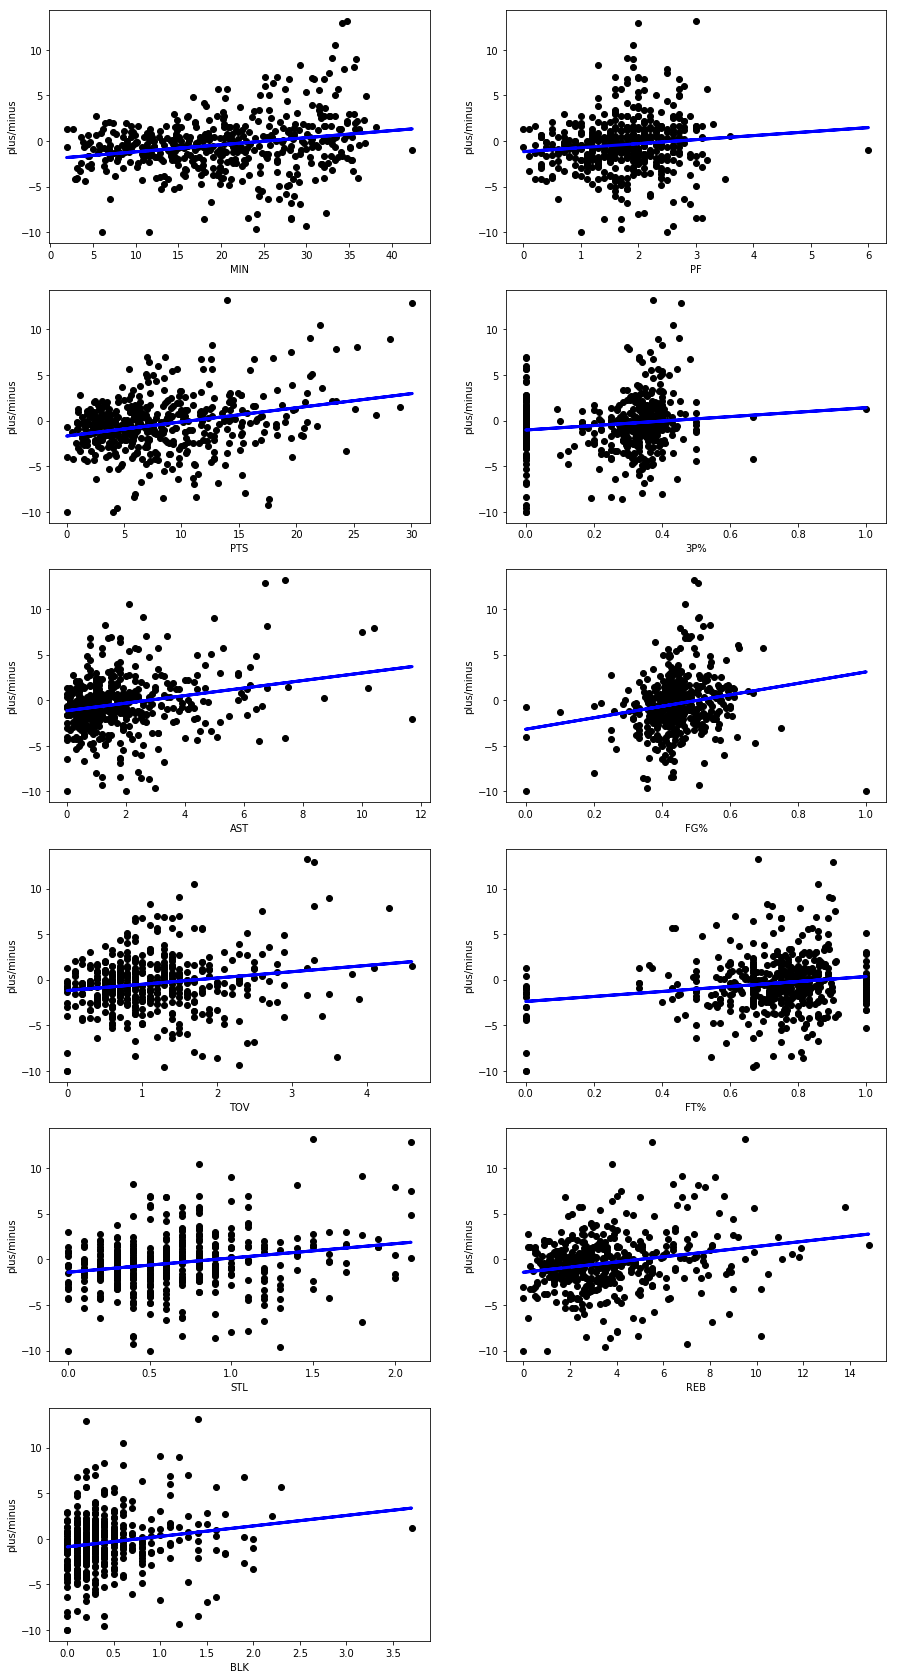

In [16]:
fig_one_feature, ax = plt.subplots(nrows = 6, ncols = 2, figsize = (15, 30))

ax[5, 1].axis('off')

for i in range(6):
    reg = linear_model.LinearRegression()
    reg.fit(NBA_data_cleaned[[relevant_features[i]]], NBA_data_cleaned[['plus/minus']])
    predictions = reg.predict(NBA_data_cleaned[[relevant_features[i]]])
    ax[i, 0].scatter(NBA_data_cleaned[relevant_features[i]], NBA_data_cleaned['plus/minus'], color='black')
    ax[i, 0].plot(NBA_data_cleaned[relevant_features[i]], predictions, color='blue', linewidth=3)
    ax[i, 0].set_xlabel(relevant_features[i])
    ax[i, 0].set_ylabel('plus/minus')
    
for i in range(5):
    reg = linear_model.LinearRegression()
    reg.fit(NBA_data_cleaned[[relevant_features[6 + i]]], NBA_data_cleaned[['plus/minus']])
    predictions = reg.predict(NBA_data_cleaned[[relevant_features[6 + i]]])
    ax[i, 1].scatter(NBA_data_cleaned[relevant_features[6 + i]], NBA_data_cleaned['plus/minus'], color='black')
    ax[i, 1].plot(NBA_data_cleaned[relevant_features[6 + i]], predictions, color='blue', linewidth=3)
    ax[i, 1].set_xlabel(relevant_features[6 + i])
    ax[i, 1].set_ylabel('plus/minus')

Now let's see which of the features results in the lowest root mean squared error.

In [17]:
def rmse_linear(feature):
    reg = linear_model.LinearRegression()
    reg.fit(NBA_data_cleaned[[feature]], NBA_data_cleaned[['plus/minus']])
    predictions = reg.predict(NBA_data_cleaned[[feature]])
    mse = mean_squared_error(y_true=NBA_data_cleaned[['plus/minus']], y_pred=predictions)
    return mse**(1/2), feature

print([rmse_linear(feature) for feature in relevant_features])

[(2.9887419348448705, 'MIN'), (2.9459978729344027, 'PTS'), (2.986297655366655, 'AST'), (3.0255185099625557, 'TOV'), (2.9955163928622137, 'STL'), (3.0298536871626336, 'BLK'), (3.0558989864354578, 'PF'), (3.047366982420386, '3P%'), (3.0228104236532936, 'FG%'), (3.029455247644301, 'FT%'), (2.996763907520203, 'REB')]


These calculations suggest we should use the following features for our linear regression model: Minutes, Points, Assists, Steals, and Rebounds.

In order to determine our training data, we'll employ the following strategy. First, we'll slice the data *by individual teams*. For each team, we will use the corresponding slice as training data for a linear regression model. Then we'll take the top 16 teams (ranked by lowest root mean squared error), use the totality of those teams as our training data, and use the rest of the teams for our test data.

In [18]:
teams = NBA_data_cleaned['TEAM'].unique()
five_features = ['MIN', 'PTS', 'AST', 'STL', 'REB']

def team_linear_regression(team):
    reg = linear_model.LinearRegression()
    X = NBA_data_cleaned[NBA_data_cleaned['TEAM'] == team][five_features]
    y = NBA_data_cleaned[NBA_data_cleaned['TEAM'] == team][['plus/minus']]
    reg.fit(X, y)
    predictions = reg.predict(NBA_data_cleaned[NBA_data_cleaned['TEAM'] != team][five_features])
    mse = mean_squared_error(y_true=NBA_data_cleaned[NBA_data_cleaned['TEAM'] != team][['plus/minus']], y_pred=predictions)
    return mse**(1/2)

print(pd.Series([team_linear_regression(team) for team in teams]).sort_values().head(16))

0     3.031277
5     3.142418
25    3.163751
8     3.354923
1     3.372606
27    3.390910
22    3.415304
14    3.419074
4     3.448207
21    3.527742
13    3.576081
23    3.587529
15    3.590032
26    3.711033
17    3.786025
29    3.824542
dtype: float64


In [19]:
training_teams = []

for i in [0, 5, 25, 8, 1, 27, 22, 14, 4, 21, 13, 23, 15, 26, 17, 29]:
    training_teams.append(teams[i])
    
print(training_teams)

['WAS', 'POR', 'CHI', 'ORL', 'UTA', 'BOS', 'DEN', 'MIA', 'SAC', 'DET', 'MIL', 'DAL', 'MEM', 'CHA', 'LAC', 'ATL']


In [20]:
#A function that slices a single team from the data
def single_team(team):
    return NBA_data_cleaned[NBA_data_cleaned['TEAM'] == team]

training_teams_df = []

for team in training_teams:
    training_teams_df.append(single_team(team))
    
training_data = pd.concat(training_teams_df)

In [21]:
# Start by saying the list of teams to test on is every team
test_teams_list = list(NBA_data_cleaned['TEAM'].unique())

# Iterate through the above list. If a team is actually a training team, remove it
for team in test_teams_list:
    if team in training_teams:
        test_teams_list.remove(team)
    
test_teams_df = []

for team in test_teams_list:
    test_teams_df.append(single_team(team))
    
testing_data = pd.concat(test_teams_df)

Alright, we have our training and testing data. Let's run regression!

In [22]:
reg = linear_model.LinearRegression()

X_train = training_data[five_features]
y_train = training_data['plus/minus']
X_test = testing_data[five_features]

reg.fit(X_train, y_train)

predictions = reg.predict(X_test)

mse = mean_squared_error(y_true = testing_data['plus/minus'], y_pred = predictions)

print(mse**(1/2))

3.3752539769500194


It appears that linear regression while training on 16 teams didn't have that much better of an effect than nearest neighbors! Of course, we can tweak our model, and use less teams to see if that makes the error smaller.

This has, hopefully, given you a glimpse of how subtle the plus/minus category can be. For now, let's end with our final insight:

### Insight 3: Optimizing a k-nearest neighbors model with 2-fold cross validation results in a more accurate model than linear regression.

There are still many questions left unanswered, and still a TON of ways to tweak the models used in this notebook, not to mention all the models we didn't even try yet!  But with the simple models we've employed so far, hopefully, if you've come this far in the notebook, you are convinced that this is an interesting problem to consider tackling.  